In [646]:
from collections import Counter
import ConfigParser
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
import csv
import os
import glob
import unicodecsv as csv
from django.utils.encoding import smart_str, smart_unicode
from TwitterAPI import TwitterAPI
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import numpy as np
import statsmodels.tsa.stattools
import re
%matplotlib inline
from textblob.sentiments import NaiveBayesAnalyzer
from django.utils.encoding import smart_str, smart_unicode
from nltk.corpus import sentiwordnet as swn
import nltk
from __future__ import division
from textblob import TextBlob
import string
import statsmodels.tsa.stattools
%matplotlib inline

In [647]:
# This method is done for you. Make sure to put your credentials in twitter.cfg.
def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = ConfigParser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
print('Established Twitter connection.')

Established Twitter connection.


In [648]:
def read_accounts(filename):
    """ Read a list of keywords to get twiiter data
    Args:
      filename: The name of the text file containing in format:
         <twitter handle>
    Returns:
      A list of (string) for search query.
    """
    candidatesList = []
    with open(filename) as candidateFile:
        for candidate in candidateFile:
            candidatesList.append(candidate.strip())
    return candidatesList

In [649]:
# I've provided the method below to handle Twitter's rate limiting.
def robust_request(twitter, resource, params, max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request.
      params ..... A parameter dictionary for the request.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200:
            return request
        else:
            print >> sys.stderr, 'Got error:', request.text, '\nsleeping for 15 minutes.'
            sys.stderr.flush()
            time.sleep(61 * 15)

In [650]:
def get_search_tweets(keywords):
    """ creates a csv file on data folder for all the search request 
    
    Args:
        keywords: a string to search in twiter data stream
    Returns:
        A list of strings, one per friend.
    Note: request iterate to all the pages and get the tweets from twitter search API every page request 
        get 200 tweets and look for naxt page for another tweets.
    """
    outf = open('/Users/Aakash/Desktop/Books/Code/cs579/aakash7864-asg/asg/Masters_projects/AppleCSV/12_01_2015/'+keywords+'_Searchtweets.csv', 'wb')
    wr = csv.writer(outf, delimiter=',', quoting=csv.QUOTE_ALL,encoding='utf-8')
    friend_list =[]
    print ('Running Twitter query for following keywords %s ' , keywords)
    request = twitter.request('search/tweets', {'q': keywords,'count':200})
    for item in request.get_iterator():
        for r in request:
            user = r['user']
            wr.writerow([r['created_at'],user['name'],user['screen_name'],smart_str(user['description']),smart_str(r['text']),r['lang'],user['favourites_count'],user['followers_count'],user['friends_count'],user['location'],user['listed_count']])
   

In [651]:
account_list=read_accounts('AppleSearchTweets.txt')

In [652]:
"""Read keywords from account list and fires search request for each keywords"""
def get_tweets_for_search(account_list):
    for acc in account_list:
        print ('Getting tweets for ', acc)
        get_search_tweets(acc)

In [653]:
"""Uncomment this block if data collection is required
    call the twiiterAPI to collect data
"""
#get_tweets_for_search(account_list)

'Uncomment this block if data collection is required\n    call the twiiterAPI to collect data\n'

In [654]:
def get_files(path,extension):
    """ Return a list of file names in this directory that end in given extension 
    The list should be sorted alphabetically by file name.
    Params:
        path....a directory containing files.
        extension...search for a particular extension
    Returns:
        a list of file names haiving extension passed inparam, sorted alphabetically.
    """
    text_files = [path + os.sep + f for f in os.listdir(path) if f.endswith(extension)]
    return text_files

In [655]:
def get_files_from_subdir(path,extension):
    """ Return a list of file names in this sub directory of a directory that end in given extension 
    The list should be sorted alphabetically by file name.
    Params:
        path....a directory containing files.
        extension...search for a particular extension
    Returns:
        a list of file names haiving extension passed in param within a subdirectory, sorted alphabetically.
    """
    path = os.getcwd()+os.sep+'data'+os.sep+path
    filelist_withdate=[]
    for subdir in os.listdir(path):
        if subdir != '.DS_Store':
             filelist_withdate.append((subdir,get_files(path + os.sep + subdir,extension)))
    return filelist_withdate

In [656]:
#start process_tweet
def processTweet(tweet):
    """ Return a filtered tweets after removing unwanted text from orignal tweets  
    Params:
        tweet....orignal tweets collected form twitter API.
    Returns:
        a filtered tweets with following conversion 
        Convert www.* or https?://* to URL,@username to AT_USER,additional white spaces,replace word with word
    """
    tweet = tweet.lower()
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    tweet = tweet.strip('\'"')
    return tweet

In [657]:
""" Filter unique tweets from csv file coolected from twitter 
    As tweets collected have lots of repeated tweets 
    Params:
        filename....csv file name where orignal tweets are stored
        filtered_tweets...tweets that are already filtered for that day
"""
def filter_repeated_tweets(filename,filtered_tweets):
    #print "running for file name ",filename
    readFile = open(filename, 'rb')
    
    file_reader = csv.reader(readFile, delimiter=',', quotechar='"')
    for row in file_reader:
        if row[5] == 'en':
            tweets=processTweet(row[4])
            if tweets not in filtered_tweets:
                filtered_tweets.append(tweets) 
    #print 'total filtered %d tweets' % len(filtered_tweets)

In [658]:
""" Creates text file for each day filtered tweets  
    Params:
        filename...file name for creation of filtered tweets 
        filtered_tweets...tweets that are already filtered for that day
"""
def create_csv_of_filtered_tweets(filename,filtered_tweets):
    #print 'total filtered %d tweets' % len(filtered_tweets)
    outf = open(os.getcwd()+os.sep+'data'+os.sep+'filterdata'+os.sep+filename+'.txt', 'wb')
    for tweets in filtered_tweets:
        outf.write(smart_str(tweets)+"\n")

In [659]:
""" Return filtered tweets that are unique among multiple csv files 
    Params:
        csv_file_list...csv file for each day
    Returns:
    filtered_tweets...tweets are unique among multiple csv files 
"""
def filter_tweets_from_csvfiles(csv_file_list):
    print 'total CSV Files %d ' % len(csv_file_list)
    filtered_tweets=[]
    for csvfile in csv_file_list:
        filter_repeated_tweets(csvfile,filtered_tweets)
    return filtered_tweets

In [660]:
""" Run filtering on rawdata collected from twitter and stores
    filtered tweets in filteredtweets directory 
    Returns:
    filtered_tweets_bydate : a Tuple (date , filtered_tweets) having date and its unique tweets
    Note:
    If you do not want to run filtering dont run this method.
"""
def run_filtering():
    csv_files=get_files_from_subdir('rawdata','.csv')
    filtered_tweets_bydate=[]
    for date,files in csv_files:
        #print files
        filtered_tweets=filter_tweets_from_csvfiles(files)
        filtered_tweets_bydate.append((date,filtered_tweets))
        create_csv_of_filtered_tweets(date,filtered_tweets)
    return filtered_tweets_bydate
#filtered_tweets_bydate=run_filtering()
#for date,data in filtered_tweets_bydate:
#    print date + 'Total Unique tweets %d ' % len(data)

In [661]:
def do_cross_val(X, y, nfolds):
    accuracies=[]
    cv = KFold(len(y), nfolds)
    for train_idx, test_idx in cv:
        clf = LogisticRegression()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        accuracies.append(acc)
    avg = np.mean(accuracies)
    return avg

In [662]:
def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()


In [663]:
def do_vectorize(tweets, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at2 least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    stop_words = ['URL','AT_USER']
    vec = CountVectorizer( tokenizer=tokenizer_fn, min_df=min_df,
                 max_df=max_df,binary=binary, ngram_range=ngram_range,stop_words=stop_words)
    data = vec.fit_transform(tweets)
    return (data,vec)

In [664]:
def readFile(filename):
    content =[]
    with open(filename) as f:
        for line in f:
            labeled_tweet = line.split('|')
            content.append(labeled_tweet)
    return content

In [665]:
def get_Y_Matrix(tweets):
    Y=[]
    for tweet in tweets:
        Y.append(tweet[0])
    return np.array(Y)

In [666]:
#lets test the advertisement classifier on unknown data to filter non ad tweets
def removeAdvertisements(source_file_name):
    #lets see how accurate the advertisement classifier is
    tweets = readFile(os.getcwd()+os.sep+'data'+os.sep+'labeldata'+os.sep+'adv_tweets_labelled.txt')
    matrix, vec= do_vectorize((t[1] for t in tweets),min_df=2)
    Y = get_Y_Matrix(tweets)
    print "The advertisement classifier is %s precent accurate" % (do_cross_val(matrix, Y,5)*100)

    new_tweets = readFile(source_file_name)
    merged_list =[]
    for t in tweets:
        merged_list.append(t[1])

    length_training_data = len(merged_list)
    for t in new_tweets:
        merged_list.append(t[0])

    new_matrix = vec.fit_transform(merged_list)    
    advt_clf = LogisticRegression()
    advt_clf.fit(new_matrix[:length_training_data], Y)
    predicted_Y = advt_clf.predict(new_matrix[length_training_data:])    

    target_file_name = re.sub('filterdata','noadvertismentdata', source_file_name)
    print target_file_name
    with open(target_file_name, 'w') as f:
        for y,t in zip(predicted_Y,new_tweets):
            if y=='0':
                f.write("%s" %t[0])    
 

In [667]:
filtered_files=get_files(os.getcwd()+os.sep+'data'+os.sep+'filterdata','.txt')
for filtered_file in filtered_files:
    print filtered_file
    removeAdvertisements(filtered_file)

/Users/Aakash/Desktop/untitledfolder/data/filterdata/11_18_2015.txt
The advertisement classifier is 76.052855925 precent accurate
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_18_2015.txt
/Users/Aakash/Desktop/untitledfolder/data/filterdata/11_19_2015.txt
The advertisement classifier is 76.052855925 precent accurate
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_19_2015.txt
/Users/Aakash/Desktop/untitledfolder/data/filterdata/11_20_2015.txt
The advertisement classifier is 76.052855925 precent accurate
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_20_2015.txt
/Users/Aakash/Desktop/untitledfolder/data/filterdata/11_21_2015.txt
The advertisement classifier is 76.052855925 precent accurate
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_21_2015.txt
/Users/Aakash/Desktop/untitledfolder/data/filterdata/11_23_2015.txt
The advertisement classifier is 76.052855925 precent accurate
/Users/Aakash/Desktop/untitledfolder/data/noad

In [668]:
#replace the neutral label 0 to act as positive. 
#this way we are classifying data in only positive(1) and negative(-1) class
def replaceLabel(Y,old_label,new_label):
    Y_neg = []  
    for label in Y:
        if label==old_label:
            Y_neg.append(new_label)
        else:
            Y_neg.append(label)
    return np.array(Y_neg)

In [669]:
def classify(source_filename, old_label,new_label):
    tweets = readFile(os.getcwd()+os.sep+'data'+os.sep+'labeldata'+os.sep+'sentiment_tweets_labelled.txt')
    X, vec= do_vectorize((t[1] for t in tweets),min_df=2)
    Y = get_Y_Matrix(tweets)

    Y_neg = replaceLabel(Y,old_label,new_label)
    
    print "The classifier with classes %s and %s is %s precent accurate" % (old_label,new_label,(do_cross_val(X, Y_neg,5)*100))

    new_tweets = readFile(source_filename)
    merged_list =[]
    for t in tweets:
        merged_list.append(t[1])

    length_training_data = len(merged_list)
    for t in new_tweets:
        merged_list.append(t[0])

    new_matrix = vec.fit_transform(merged_list)    
    clf = LogisticRegression()
    clf.fit(new_matrix[:length_training_data], Y_neg)
    predicted_Y = clf.predict(new_matrix[length_training_data:])    
    predict_proba = clf.predict_proba(new_matrix[length_training_data:])
    return (predicted_Y,predict_proba)

In [670]:
def getMostProbableClass(probabilities):
    #get max amongst three
    max_prob=probabilities[0];
    max_index=0;
    for i in range(1,3):
        if probabilities[i]>max_prob:
            max_prob=probabilities[i]
            max_index=i
    return max_index-1    

In [671]:
def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()

In [672]:
""" Return the polarity of the text using TextBlob subjective setiment analyser  
    Params:
        text....Tweets that re filtered and have no advertisment.
        tokenizer_fn...Tokenizer for analysis
    Returns:
        Polarity of a tweets
    Note: We have tried Naive Bayes Analyzer and PatternAnalyzer and we choosed PatternAnalyzer beacuse 
    1: Result looks more accurate than Naive Bayes 
    2: Running Naive Bayes Analyzer with text blob takes lots of time to run without giving any significant 
       output result.
"""
def sentiment_analysis(text,tokenizer_fn=tokenize):
    #polarity=0
    #subj=0
    #unicode_test=re.sub(r'[^\x00-\x7F]+',' ', text)
    blob = TextBlob(re.sub(r'[^\x00-\x7F]+',' ', text))
    #sent = TextBlob(unicode_test, analyzer=NaiveBayesAnalyzer())
    #classification = sent.sentiment.classification
    #p_pos = sent.sentiment.p_pos
    #p_neg = sent.sentiment.p_neg
    #print p_pos,p_neg,blob.sentiment.polarity,blob.sentiment.subjectivity
    #print blob.sentiment.polarity,blob.sentiment.subjectivity
    return (blob.sentiment.polarity)

In [673]:
""" Return a list of Tuple(filename,sentiment for each tweets) 
    Params:
        filenames....File list contaning tweets to run textBlob sentiment on.
    Returns:
        setiment_of_all_tweets...A list of Tuple(filename,sentiment for each tweets) 
"""
def run_sentiment(filenames):
    setiment_of_all_tweets=[]
    
    for fname in filenames:
        with open(fname) as f:
            tweets_sentiment_list=[]
            for line in f:
                tweets_sentiment_list.append((line,sentiment_analysis(line,tokenize)))
            setiment_of_all_tweets.append((fname,tweets_sentiment_list))
            
    return setiment_of_all_tweets

     

In [674]:
#Run Textbob sentiment on those tweets having no advertisment and are filtered as well 

no_advertisment_files=get_files(os.getcwd()+os.sep+'data'+os.sep+'noadvertismentdata','.txt')
sentiment_of_tweets=run_sentiment(no_advertisment_files)
#print sentiment_of_tweets
""" Return a list of tuple having 
    (filename, avgerage of positive sentiment for that day ,
    avgerage of negative sentiment for that day ,Percentage of Positive Tweets for that day,
    Percentage of Negative Tweets for that day, Percentage of Neutral Tweets for that day)
    Params:
        sentiment_of_tweets....A list of Tuple(filename,sentiment for each tweets) 
    Returns:
        tweets_sentiment_per_day...A list  a list of tuple having 
        (filename, avgerage of positive sentiment for that day ,
        avgerage of negative sentiment for that day ,Percentage of Positive Tweets for that day,
        Percentage of Negative Tweets for that day, Percentage of Neutral Tweets for that day)
"""
def setiment_perday_by_TextBlob(sentiment_of_tweets):
    tweets_sentiment_per_day=[]
    for filename,alltweets in sentiment_of_tweets:
        pos_tweetscount = 0
        neg_tweetscount = 0
        neu_tweetscount = 0
        avg_positive_sentiment_day = 0
        avg_negative_sentiment_day=0
        pos_tweets=0
        neg_tweets =0
        percentage_positive_tweets=0
        percentage_negative_tweets=0
        percentage_neutral_tweets=0
        totaltweets_perday=0
        for allsentiment in alltweets:
            if allsentiment[1]>0:
                pos_tweetscount=pos_tweetscount+1
                pos_tweets= pos_tweets+allsentiment[1]
            elif allsentiment[1]<0:
                neg_tweetscount=neg_tweetscount+1
                neg_tweets=neg_tweets+allsentiment[1]
            else:
                neu_tweetscount=neu_tweetscount+1
        totaltweets=len(alltweets)
        avg_positive_sentiment_day= pos_tweets / pos_tweetscount
        avg_negative_sentiment_day= neg_tweets / neg_tweetscount
        percentage_positive_tweets = (pos_tweetscount / totaltweets) * 100
        percentage_negative_tweets = (neg_tweetscount / totaltweets) * 100
        percentage_neutral_tweets = (neu_tweetscount / totaltweets) * 100
        tweets_sentiment_per_day.append((filename,avg_positive_sentiment_day,avg_negative_sentiment_day,percentage_positive_tweets,percentage_negative_tweets,percentage_neutral_tweets))                                
    return tweets_sentiment_per_day
tweets_sentiment_per_day=setiment_perday_by_TextBlob(sentiment_of_tweets)
for filename,avgpos,avgneg,perpos,perneg,perneu  in tweets_sentiment_per_day:
    print filename 
    neutral = 1 - (avgpos + abs(avgneg)) 
    print avgpos,avgneg,neutral

/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_18_2015.txt
0.358618500358 -0.236956184787 0.404425314855
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_19_2015.txt
0.335720479809 -0.259641524048 0.404637996143
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_20_2015.txt
0.341327425301 -0.293621132702 0.365051441997
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_21_2015.txt
0.362908998825 -0.317614730128 0.319476271047
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_23_2015.txt
0.341832605435 -0.211727430556 0.44643996401
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_25_2015.txt
0.374202699851 -0.270775732317 0.355021567832
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_27_2015.txt
0.372641765851 -0.355698743386 0.271659490763
/Users/Aakash/Desktop/untitledfolder/data/noadvertismentdata/11_28_2015.txt
0.36361653355 -0.241680877306 0.394702589144
/Users/Aakash/Desktop/unti

In [675]:
no_advertisment_files=get_files(os.getcwd()+os.sep+'data'+os.sep+'noadvertismentdata','.txt')
days_Yfinal=[]
for filtered_file in no_advertisment_files:
    neg_predicted_Y, neg_predict_proba = classify(filtered_file,'0','1')
    pos_predicted_Y, pos_predict_proba = classify(filtered_file,'0','-1')
    neut_predicted_Y, neut_predict_proba = classify(filtered_file,'-1','1')
    Y_final = []
    for p_neg,p_pos,p_neut in zip (neg_predict_proba,pos_predict_proba,neut_predict_proba):
        Y_final.append(getMostProbableClass([p_neg[0],p_neut[0],p_pos[1]]))
    yval=Counter(Y_final)
    total= yval[1]+yval[0]+yval[-1]
    days_Yfinal.append((filtered_file,(yval[1]/total,yval[-1]/total,yval[0]/total)))
for filename,senti in days_Yfinal:
    print filename
    print senti


The classifier with classes 0 and 1 is 75.2711864407 precent accurate
The classifier with classes 0 and -1 is 66.2033898305 precent accurate
The classifier with classes -1 and 1 is 64.2429378531 precent accurate
The classifier with classes 0 and 1 is 75.2711864407 precent accurate
The classifier with classes 0 and -1 is 66.2033898305 precent accurate
The classifier with classes -1 and 1 is 64.2429378531 precent accurate
The classifier with classes 0 and 1 is 75.2711864407 precent accurate
The classifier with classes 0 and -1 is 66.2033898305 precent accurate
The classifier with classes -1 and 1 is 64.2429378531 precent accurate
The classifier with classes 0 and 1 is 75.2711864407 precent accurate
The classifier with classes 0 and -1 is 66.2033898305 precent accurate
The classifier with classes -1 and 1 is 64.2429378531 precent accurate
The classifier with classes 0 and 1 is 75.2711864407 precent accurate
The classifier with classes 0 and -1 is 66.2033898305 precent accurate
The classif

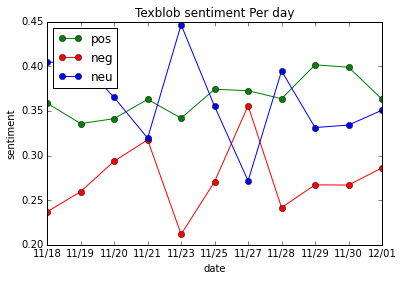

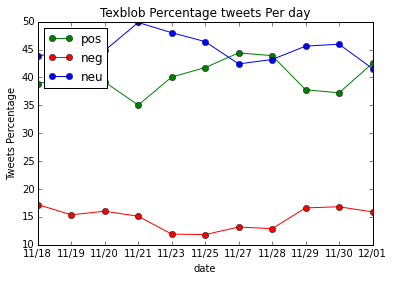

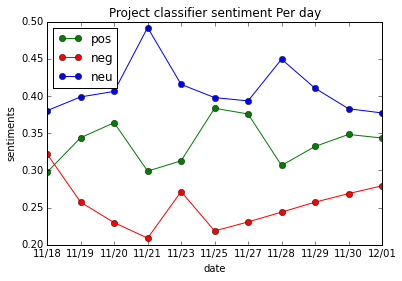

In [725]:
file_names=[]
avg_pos_list=[]
avg_neg_list=[]
avg_neu_list=[]
per_pos_list=[]
per_pos_list=[]
per_neg_list=[]
per_neu_list=[]
for filename,avgpos,avgneg,perpos,perneg,perneu  in tweets_sentiment_per_day:
    neutral = 1 - (avgpos + abs(avgneg)) 
    updated_file_name=re.sub(os.getcwd()+os.sep+'data'+os.sep+'noadvertismentdata'+os.sep,'', filename)
    without_txt=re.sub('.txt','', updated_file_name)
    removing_=re.sub('_','/', without_txt)
    file_names.append(re.sub('/2015','', removing_))
    avg_pos_list.append(avgpos)
    avg_neg_list.append(abs(avgneg))
    avg_neu_list.append(1-(avgpos+abs(avgneg)))
    per_pos_list.append(perpos)
    per_neg_list.append(perneg)
    per_neu_list.append(perneu)

plt.rcParams.update({'font.size': 10})
plt.figure()
plt.plot(avg_pos_list, 'go-',label="pos")
plt.plot(avg_neg_list, 'ro-',label="neg")
plt.plot(avg_neu_list, 'bo-',label="neu")
plt.xlabel('date')
plt.ylabel('sentiment')
plt.legend(loc='upper left')
plt.xticks(range(len(file_names)), file_names)
plt.title('Texblob sentiment Per day')
plt.show()
    
plt.rcParams.update({'font.size': 10})
plt.figure()
plt.plot(per_pos_list, 'go-',label="pos")
plt.plot(per_neg_list, 'ro-',label="neg")
plt.plot(per_neu_list, 'bo-',label="neu")
plt.xlabel('date')
plt.ylabel('Tweets Percentage')
plt.legend(loc='upper left')
plt.xticks(range(len(file_names)), file_names)
plt.title('Texblob Percentage tweets Per day')
plt.show()

classifire_pos_list=[]
classifire_neg_list=[]
classifire_neu_list=[]
for filename,senti in days_Yfinal:
    classifire_pos_list.append(senti[0])
    classifire_neg_list.append(senti[1])
    classifire_neu_list.append(senti[2])


plt.rcParams.update({'font.size': 10})
plt.figure()
plt.plot(classifire_pos_list, 'go-',label="pos")
plt.plot(classifire_neg_list, 'ro-',label="neg")
plt.plot(classifire_neu_list, 'bo-',label="neu")
plt.xlabel('date')
plt.ylabel('sentiments')
plt.legend(loc='upper left')
plt.xticks(range(len(file_names)), file_names)
plt.title('Project classifier sentiment Per day')
plt.show()

In [677]:
import statistics

def get_setiment_direction():

    """ A list of Tuple (date, sentiment for that day)
    sentiment for that day : is calculated as follows
    1: Take mean for all days positive sentiment,negative sentiment,neutral sentiment
    2: Calculate differnece for each day for variation in sentiment from its mean
       For Postive variation = Postive Mean of alldays - today Postive sentiment
    3: Sum all postive,negative and neutral variation to get the sentiment direction for that day
    Returns:
        A list of Tuple (date, sentiment for that day)
    """
    total_variation=[]
    avg_pos_list=[]
    avg_neg_list=[]
    avg_neu_list=[]
    dates=[]
    for i in range(len(days_Yfinal)):
        filename,avgpos,avgneg,perpos,perneg,perneu=tweets_sentiment_per_day[i]
        filename,senti=days_Yfinal[i]
        avg_pos_of_day=(avgpos+senti[0])/2
        avg_neg_of_day=(abs(avgneg) + senti[1])/2
        avg_neu_of_day=(neutral+senti[2])/2
        avg_pos_list.append(avg_pos_of_day)
        avg_neg_list.append(avg_neg_of_day)
        avg_neu_list.append(avg_neu_of_day)
        updated_file_name=re.sub(os.getcwd()+os.sep+'data'+os.sep+'noadvertismentdata'+os.sep,'', filename)
        dates.append(re.sub('.txt','', updated_file_name))
    pos_mean= statistics.mean(avg_pos_list)
    neg_mean=  statistics.mean(avg_neg_list)
    neu_mean=  statistics.mean(avg_neu_list)
    for i in range(len(avg_pos_list)):
        pos_variation=pos_mean- avg_pos_list[i]
        neg_variation=neg_mean- avg_neg_list[i]
        neu_variation=neu_mean- avg_neu_list[i]
        #print pos_variation,neg_variation,neu_variation
        total_variation.append((dates[i],(pos_variation+neg_variation+neu_variation)))
    return total_variation

[('11_18_2015', 0.021412898771619726), ('11_19_2015', 0.021519239415912328), ('11_20_2015', 0.001725962343024412), ('11_21_2015', -0.021061623132375806), ('11_23_2015', 0.042420223349276864), ('11_25_2015', -0.0032889747394810043), ('11_27_2015', -0.044970013274152176), ('11_28_2015', 0.01655153591612729), ('11_29_2015', -0.01513760623444188), ('11_30_2015', -0.01373977302037388), ('12_01_2015', -0.005431869395136235)]


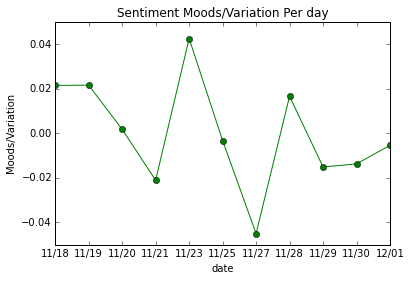

In [727]:
senti_direction=get_setiment_direction()
print senti_direction
senti_direc_list=[]
for date,senti in senti_direction:
    senti_direc_list.append(senti)


    
    
plt.rcParams.update({'font.size': 10})
plt.figure()
plt.plot(senti_direc_list, 'go-')
plt.xlabel('date')
plt.ylabel('Moods/Variation')
plt.xticks(range(len(file_names)), file_names)
plt.title('Sentiment Moods/Variation Per day')
plt.show()

In [750]:

from yahoo_finance import Share
import csv
def getStockData(start_date,end_date,company,file_name):
    company_share = Share(company)
    stock_data_list = company_share.get_historical(start_date,end_date)
    print stock_data_list
    with open(file_name, 'ab') as fp:
        csv_writer = csv.writer(fp, delimiter=',')
        for record in stock_data_list:
            print record.values()[1:] 
            #csv_writer.writerow(record.values()[1:])
    
    
    
    
stock_data_list=getStockData('2015-11-18','2015-12-01','AAPL','apple.csv')

[{'Volume': '34701000', 'Symbol': 'AAPL', 'Adj_Close': '117.339996', 'High': '118.809998', 'Low': '116.860001', 'Date': '2015-12-01', 'Close': '117.339996', 'Open': '118.75'}, {'Volume': '37658700', 'Symbol': 'AAPL', 'Adj_Close': '118.300003', 'High': '119.410004', 'Low': '117.75', 'Date': '2015-11-30', 'Close': '118.300003', 'Open': '117.989998'}, {'Volume': '13023700', 'Symbol': 'AAPL', 'Adj_Close': '117.809998', 'High': '118.410004', 'Low': '117.599998', 'Date': '2015-11-27', 'Close': '117.809998', 'Open': '118.290001'}, {'Volume': '21388300', 'Symbol': 'AAPL', 'Adj_Close': '118.029999', 'High': '119.230003', 'Low': '117.919998', 'Date': '2015-11-25', 'Close': '118.029999', 'Open': '119.209999'}, {'Volume': '42803200', 'Symbol': 'AAPL', 'Adj_Close': '118.879997', 'High': '119.349998', 'Low': '117.120003', 'Date': '2015-11-24', 'Close': '118.879997', 'Open': '117.330002'}, {'Volume': '32482500', 'Symbol': 'AAPL', 'Adj_Close': '117.75', 'High': '119.730003', 'Low': '117.339996', 'Date

In [728]:
def get_stock_open_close_diff(filename):
    #print "running for file name ",filename
    readFile = open(filename, 'rb')
    stock_val_diff=[]
    file_reader = csv.reader(readFile, delimiter=',', quotechar='"')
    for row in file_reader:
        stock_val_diff.append((row[4],(float(row[5])-float(row[6]))))
    return stock_val_diff

def match_stock_direction(stock_val_dif):
    stock_dates=[]
    setiment_dates=[]
    senti_stock_comparison = []
    for date,stock_val in stock_val_dif:
        for senti_date,sentiment in senti_direction:
            if re.sub('_' ,'-', senti_date)==date:
                direction_match='opposite'
                if stock_val>0 and sentiment>0:
                    direction_match='same'
                elif stock_val<0 and sentiment<0:
                    direction_match='same'
                senti_stock_comparison.append((date,direction_match,sentiment,stock_val))
    return senti_stock_comparison

stock_val_dif=get_stock_open_close_diff('apple.csv')
senti_stock_comparison=match_stock_direction(stock_val_dif)




12-01-2015 same
-0.00543186939514 -1.410004
11-30-2015 opposite
-0.0137397730204 0.310005
11-27-2015 same
-0.0449700132742 -0.480003
11-25-2015 same
-0.00328897473948 -1.18
11-23-2015 opposite
0.0424202233493 -1.519997
11-20-2015 same
0.00172596234302 0.100006
11-19-2015 same
0.0215192394159 1.14
11-18-2015 same
0.0214128987716 1.529999


[-0.18957658738577068, -0.47952907022946467, -1.5694894392785301, -0.11478784958767863, 1.4804997310684418, 0.06023746654142639, 0.7510386710068729, 0.7473272974485456]
[-1.4100040000000007, 0.31000500000000386, -0.4800030000000106, -1.1799999999999926, -1.5199970000000036, 0.10000600000000759, 1.1400000000000006, 1.5299990000000037]


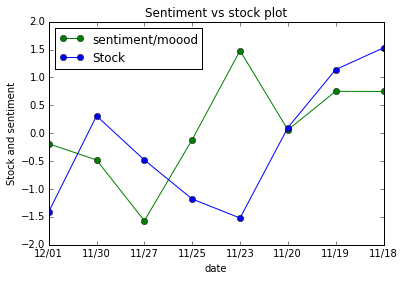

In [744]:
senti_val_list=[]
stock_val_list=[]
stock_days_list=[]
for date,direction,senti_val,stock_val in senti_stock_comparison:
    senti_val_list.append(senti_val*34.9008)
    stock_val_list.append(stock_val)
    updated_file_name=re.sub('-2015','', date)
    stock_days_list.append(re.sub('-','/', updated_file_name))
print senti_val_list
print stock_val_list
    
plt.rcParams.update({'font.size': 10})
plt.figure()
plt.plot(senti_val_list, 'go-',label="sentiment/moood")
plt.plot(stock_val_list, 'bo-',label="Stock")
plt.xlabel('date')
plt.ylabel('Stock and sentiment')
plt.legend(loc='upper left')
plt.xticks(range(len(stock_days_list)), stock_days_list)
plt.title('Sentiment vs stock plot')
plt.show()

In [748]:
def predict_stock(beforeday):
    stockvalfordays=[]
    sentivalfordays=[]
    for i in range(len(senti_stock_comparison)-1,beforeday,-1):
        date,direction,senti_val,stockval=senti_stock_comparison[i]
        stockvalfordays.append(stockval)
        sentivalfordays.append(senti_val)
    stock_range=max(stockvalfordays)+abs(min(stockvalfordays))
    steni_range=max(sentivalfordays)+abs(min(sentivalfordays))
    threashold=stock_range/steni_range
    date,direction,senti_val,stockval=senti_stock_comparison[beforeday]
    return((stockval,senti_val*threashold))
print predict_stock(0),predict_stock(1),predict_stock(2),predict_stock(3)

(-1.4100040000000007, -0.1895770118929552) (0.31000500000000386, -0.47953014400939864) (-0.4800030000000106, -3.0006730885931976) (-1.1799999999999926, -0.22723049890281943)


In [754]:
def get_stock_close_value(filename):
    #print "running for file name ",filename
    readFile = open(filename, 'rb')
    stock_closing_val=[]
    file_reader = csv.reader(readFile, delimiter=',', quotechar='"')
    for row in file_reader:
        stock_closing_val.append((row[4],float(row[6])))
    return stock_closing_val
 

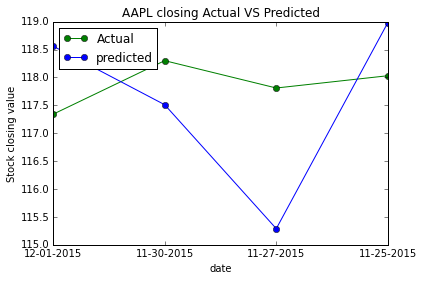

In [763]:

stock_closing_val=get_stock_close_value('apple.csv')
actual_stock_closing_list=[]
predicted_stock_closing_list=[]
datelist=[]
for i in range(4):
    date,openvalue=stock_closing_val[i]
    actualvalue,predictedvalue=predict_stock(i)
    actual_stock_closing_list.append(openvalue+actualvalue)
    predicted_stock_closing_list.append((openvalue+predictedvalue))
    datelist.append(date)

plt.rcParams.update({'font.size': 10})
plt.figure()
plt.plot(actual_stock_closing_list, 'go-',label='Actual')
plt.plot(predicted_stock_closing_list, 'bo-',label="predicted")
plt.xlabel('date')
plt.ylabel('Stock closing value')
plt.legend(loc='upper left')
plt.xticks(range(len(datelist)), datelist)
plt.title('AAPL closing Actual VS Predicted')
plt.show()